# RFM ANALİZİ 

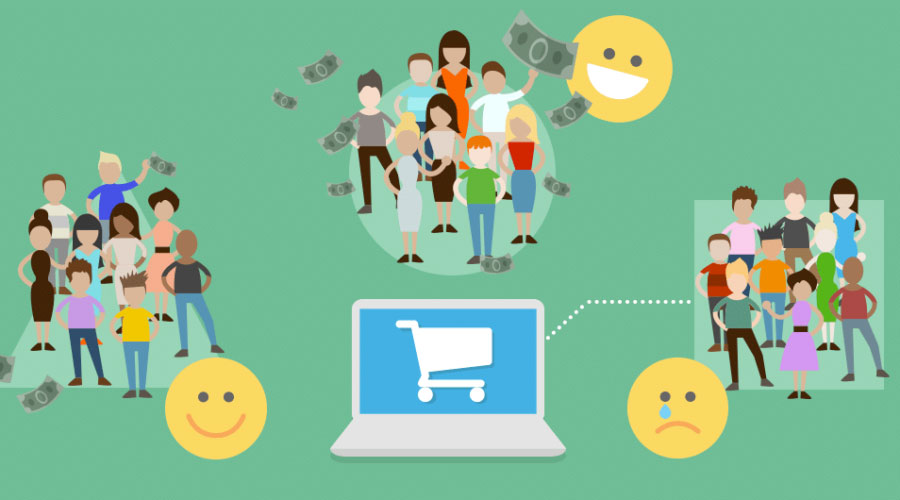

In [1]:
### İçindekiler

# 1.Importing
# 2.Veriyi anlama
# 3.RFM Analizi
# 4.Yorum ve öneriler

## 1.Importing

In [2]:
import datetime as dt
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_=pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2010-2011" )
df=df_.copy()

## 2.Veriyi Anlama

In [4]:
# Değişkenler

# InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.
# StockCode: Ürün kodu. Her bir ürün için eşsiz numara.
# Description: Ürün ismi
# Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
# InvoiceDate: Fatura tarihi ve zamanı.
# UnitPrice: Ürün fiyatı (Sterlin cinsinden)
# CustomerID: Eşsiz müşteri numarası
# Country: Ülke ismi. Müşterinin yaşadığı ülke.

In [15]:
#Veri setinin ilk 5 gözlemi
print("#######################")
print(df.head())
# Veri setinin betimsel istatistikleri
print("#######################")
print(df.describe().T)
# Veri setinin boyutları
print("#######################")
print("Verinin boyutları:",df.shape)
# Veri setinde hangi değişkende kaç tane eksik gözlem vardır?
print("#######################")
print("Verideki boş değişkenler")
print(df.isnull().sum())
# Eksik verilerin veri setinden çıkartılması
df.dropna(inplace=True)    



#######################
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  
0 2010-12-01 08:26:00   2.55     17850.00  United Kingdom       15.30  
1 2010-12-01 08:26:00   3.39     17850.00  United Kingdom       20.34  
2 2010-12-01 08:26:00   2.75     17850.00  United Kingdom       22.00  
3 2010-12-01 08:26:00   3.39     17850.00  United Kingdom       20.34  
4 2010-12-01 08:26:00   3.39     17850.00  United Kingdom       20.34  
#######################
                count     mean     std      min      25%      50%      75%  \
Quantity    397885.00

Not:Boş değişkenlerin silinmesi veri kaybına sebep olabilir.
Ancak veri setimizin örnek sayısı fazla olduğundan bu kayıp göz ardı edilebilir

In [6]:
# Eşsiz ürün sayısı kaçtır?
print("#######################")
print("Eşsiz ürün sayısı:",df["Description"].nunique())
# Hangi üründen kaçar tane vardır?
print("#######################")
print(df.groupby("Description").agg({"StockCode":"count"}).sort_values(by="StockCode",ascending=False))

#######################
Eşsiz ürün sayısı: 3896
#######################
                                    StockCode
Description                                  
WHITE HANGING HEART T-LIGHT HOLDER       2070
REGENCY CAKESTAND 3 TIER                 1905
JUMBO BAG RED RETROSPOT                  1662
ASSORTED COLOUR BIRD ORNAMENT            1418
PARTY BUNTING                            1416
...                                       ...
BLUE NEW BAROQUE FLOCK CANDLESTICK          1
IVORY SHELL HEART EARRINGS                  1
BLUE PAINTED KASHMIRI CHAIR                 1
IVORY PANTRY HANGING LAMP                   1
MINT DINER CLOCK                            1

[3896 rows x 1 columns]


Faturalardaki ‘C’ iptal edilen işlemleri göstermektedir.Bu yüzden iptal edilen işlemleri veri setinden çıkaracağız

In [7]:
df=df[~df["Invoice"].str.contains("C",na=False)]

Fatura başına elde edilen toplam kazancı ifade eden ‘TotalPrice’ adında bir değişken oluşturunuz

In [8]:
df["TotalPrice"] = df["Quantity"] * df["Price"]
df=df[df["TotalPrice"]>0]

## 3.RFM Analizi

RFM metriklerinin hesaplanması

In [9]:
df["InvoiceDate"].max()
today_date=dt.datetime(2011,12,11)
# Veri setindeki son yapılan alışveriş tarihinden 2 gün sonrası Receny değişkeni için referans noktası olarka belirlendi

rfm=df.groupby("Customer ID").agg({"InvoiceDate": lambda x :(today_date-x.max()).days,
                               "Invoice": lambda x : x.nunique(),
                               "TotalPrice":lambda x : x.sum()})

rfm.columns=["recency","frequency","monetary"]

rfm=rfm[rfm["monetary"]>0]



RFM skorlarının oluşturulması ve tek bir değişkene çevrilmesi

In [11]:
rfm["receny_score"] = pd.qcut(rfm["recency"],5,labels=[5,4,3,2,1])

rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"),5,labels=[1,2,3,4,5])

rfm["monetary_score"] = pd.qcut(rfm["monetary"],5,labels=[1,2,3,4,5])

rfm["rfm_score"]=rfm["receny_score"].astype("str")+rfm["frequency_score"].astype("str")

RFM skorlarının segment olarak tanımlanması

In [12]:

seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}


rfm['segment'] = rfm['rfm_score'].replace(seg_map, regex=True)

rfm.reset_index()

version1=rfm.groupby("segment").agg({"recency":["mean","count"],
                            "frequency":["mean","count"],
                            "monetary":["mean","count"]})


In [14]:
rfm.head(10)

,recency,frequency,monetary,receny_score,frequency_score,monetary_score,rfm_score,segment
Customer ID,,,,,,,,
12346.00,326,1,77183.60,1,1,5,11,hibernating
12347.00,3,7,4310.00,5,5,5,55,champions
12348.00,76,4,1797.24,2,4,4,24,at_Risk
12349.00,19,1,1757.55,4,1,4,41,promising
12350.00,311,1,334.40,1,1,2,11,hibernating
12352.00,37,8,2506.04,3,5,5,35,loyal_customers
12353.00,205,1,89.00,1,1,1,11,hibernating
12354.00,233,1,1079.40,1,1,4,11,hibernating
12355.00,215,1,459.40,1,1,2,11,hibernating


In [17]:
version1

recency       frequency       monetary      
                       mean count      mean count     mean count
segment                                                         
about_to_sleep        53.31   352      1.16   352   471.99   352
at_Risk              153.79   593      2.88   593  1084.54   593
cant_loose           132.97    63      8.38    63  2796.16    63
champions              6.36   633     12.41   633  6857.96   633
hibernating          217.61  1071      1.10  1071   488.64  1071
loyal_customers       33.61   819      6.48   819  2864.25   819
need_attention        52.43   187      2.33   187   897.63   187
new_customers          7.43    42      1.00    42   388.21    42
potential_loyalists   17.40   484      2.01   484  1041.22   484
promising             23.51    94      1.00    94   294.01    94

# 4.Yorum ve öneriler

Pareto prensibi der ki: Gelirinizin %80'ini müşterilerinizin %20'si oluşturur.
Bu yüzden en çok gelir elde ettiğimiz segmentlerin bizim için önemli olduğunu düşünüyorum.

In [18]:
rfm.groupby("segment")["monetary"].sum().sort_values(ascending=False)

segment
champions             4341091.16
loyal_customers       2345818.94
at_Risk                643129.43
hibernating            523336.98
potential_loyalists    503951.45
cant_loose             176157.82
need_attention         167856.41
about_to_sleep         166142.02
promising               27636.75
new_customers           16304.94
Name: monetary, dtype: float64

Çıkan sonuca göre diyebilirim ki champions ve loyal_customers benim için açık ara en önemli iki segment

In [26]:
print("Champions")
print(rfm[rfm["segment"]=="champions"].describe().T)
print("\n Loyal Customers")
print(rfm[rfm["segment"]=="loyal_customers"].describe().T)

Champions
           count    mean      std    min     25%     50%     75%       max
recency   633.00    6.36     3.68   1.00    3.00    5.00   10.00     13.00
frequency 633.00   12.41    16.45   3.00    5.00    8.00   14.00    209.00
monetary  633.00 6857.96 20339.76 201.12 1451.28 2612.96 4954.84 280206.02

 Loyal Customers
           count    mean     std   min    25%     50%     75%       max
recency   819.00   33.61   15.58 15.00  20.00   30.00   44.00     72.00
frequency 819.00    6.48    4.55  3.00   4.00    5.00    8.00     63.00
monetary  819.00 2864.25 6007.06 36.56 991.80 1740.48 3052.91 124914.53


In [29]:
print("Frequency değişkenine göre segmentlerin ortalaması")
print(rfm.groupby("segment")["frequency"].mean().sort_values(ascending=False))
print("\nRecency değişkenine göre segmentlerin ortalaması")
print(rfm.groupby("segment")["recency"].mean().sort_values(ascending=True))

Frequency değişkenine göre segmentlerin ortalaması
segment
champions             12.41
cant_loose             8.38
loyal_customers        6.48
at_Risk                2.88
need_attention         2.33
potential_loyalists    2.01
about_to_sleep         1.16
hibernating            1.10
promising              1.00
new_customers          1.00
Name: frequency, dtype: float64

Recency değişkenine göre segmentlerin ortalaması
segment
champions               6.36
new_customers           7.43
potential_loyalists    17.40
promising              23.51
loyal_customers        33.61
need_attention         52.43
about_to_sleep         53.31
cant_loose            132.97
at_Risk               153.79
hibernating           217.61
Name: recency, dtype: float64


Yukarıdaki bilgilere göre incelediğimde "champions" her alanda zirvede. Bu yüzden onlar için hiçbir şey yapmam.
Onlara yapacağım her aksiyon iyi ya da kötü risk taşıyor.Düzgün giden bir davranışı bozmak istemem.

"loyal customers" segmenti benim için en önemli ikinci segment olmasına rağmen frekans değerleri açısından 3. recency değerleri
açısından 5. sırada. Son zamanlarda ilgileri biraz azalmış.Bunu arttırmaya çalışmak faydalı olabilir.